# Comparing Kriging and CoKriging

<!-- SUMMARY: The Simulation post-processing is illustrated through an Upscaling capability -->

<!-- CATEGORY: Data_Base_Management -->

These tests mean to demonstrate the use of CoKriging in Heterotopic case. A second part also demonstrates the various cases of CoKriging simplifications, i.e. when Cokriging of several variables simplifies into one or several Kriging of each variable individually.

In [1]:
import gstlearn as gl
import gstlearn.plot as gp
import gstlearn.document as gdoc
import numpy as np
import matplotlib.pyplot as plt
import gstlearn.plot as gp
import scipy.sparse as sc

gdoc.setNoScroll()

<IPython.core.display.Javascript object>

## CoKriging vs. Kriging in 2-D

We create a grid and two models

In [2]:
grid = gl.DbGrid.create(nx=[300,200])
modelC = gl.Model.createFromParam(gl.ECov.CUBIC,range=40)
modelE = gl.Model.createFromParam(gl.ECov.EXPONENTIAL,range=20)

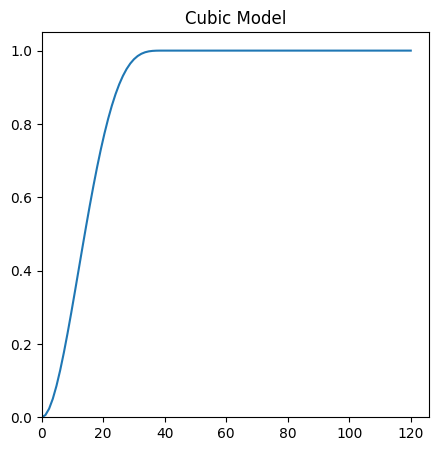

In [3]:
ax = gp.model(modelC) 
ax.decoration(title="Cubic Model")

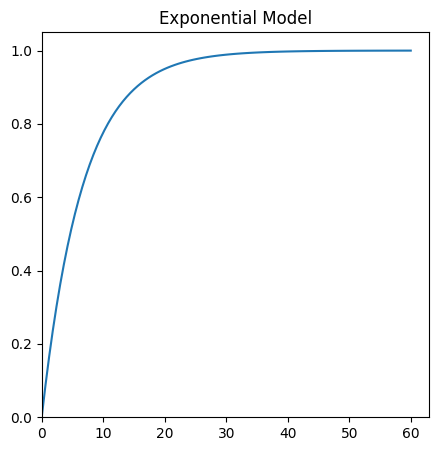

In [4]:
ax = gp.model(modelE)
ax.decoration(title="Exponential Model")

### Working on exhaustive grids

We simulate two underlying GRFs exhaustively on the grid

In [5]:
err = gl.simtub(None,grid,modelC)
grid.setName("Simu", "S1")
err = gl.simtub(None,grid,modelE)
grid.setName("Simu", "S2")

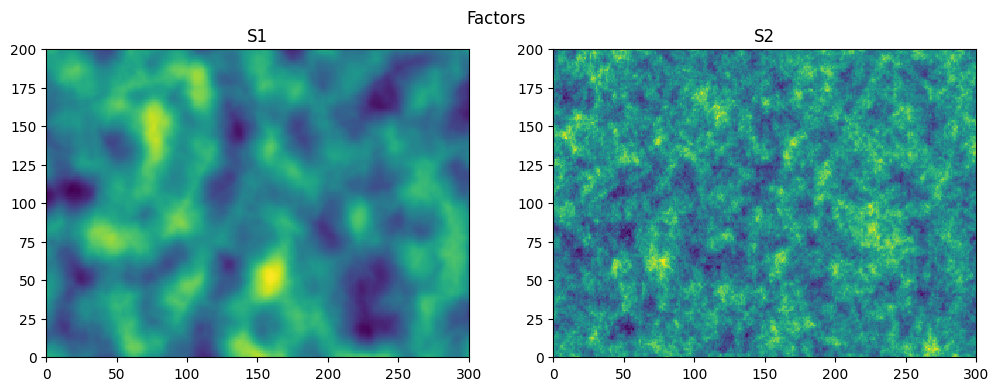

In [6]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,2,1)
ax1 = gp.raster(grid,name="S1")
ax2 = fig.add_subplot(1,2,2)
ax2 = gp.raster(grid,name="S2")
fig.decoration(title="Factors")

Calculating the variograms on the two Factors benefiting from the Grid organization. We can check that they are point-wise and spatially independent.

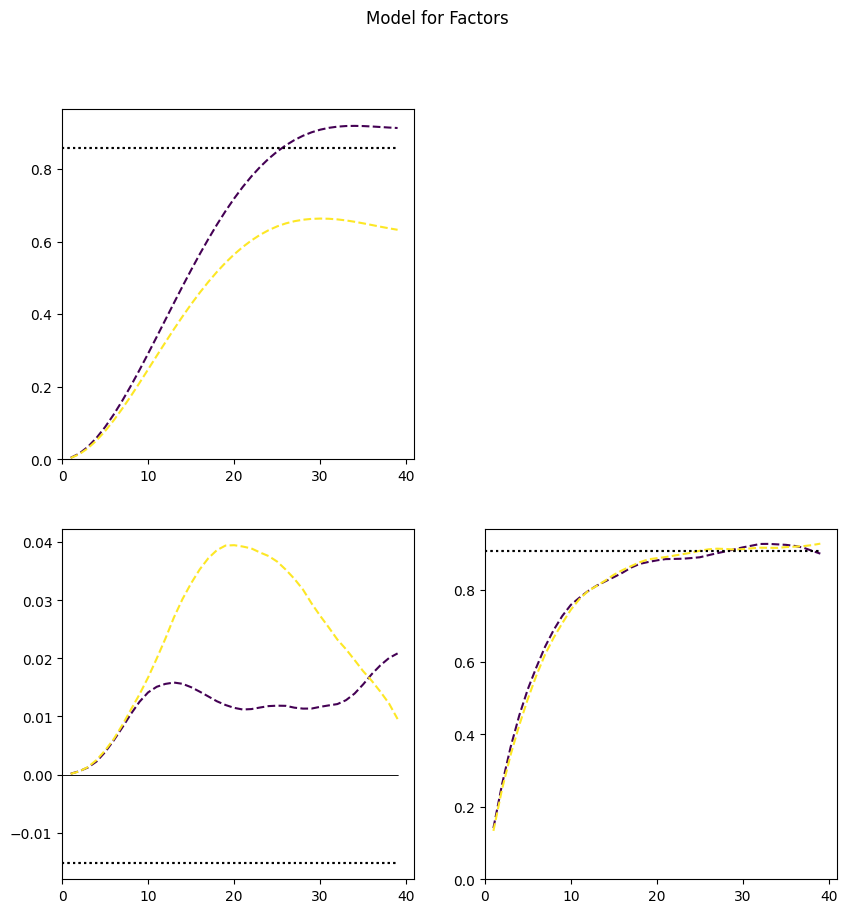

In [7]:
grid.setLocators(["S*"],gl.ELoc.Z)

nlag=40
varioParamG = gl.VarioParam.createMultipleFromGrid(grid,nlag)
vario = gl.Vario.computeFromDb(varioParamG, grid)

axs = gp.varmod(vario)
gp.decoration(axs, title="Model for Factors")

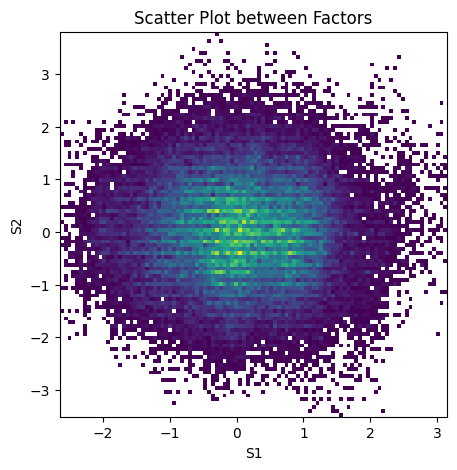

In [8]:
ax = gp.correlation(grid, "S1", "S2", bins=100, cmin=1)
ax.decoration(title="Scatter Plot between Factors")

We define an internal function that generates two variables obtained as mixtures of the two underlying factors

In [9]:
def variable_generate(grid, c1, c2):
  grid["Z1"] = c1[0] * grid["S1"] + c1[1] * grid["S2"]
  grid["Z2"] = c2[0] * grid["S1"] + c2[1] * grid["S2"]
  grid.setLocators(["Z*"],gl.ELoc.Z)

Create the two variables of interest

In [10]:
c1 = [3,1]
c2 = [1,2]
variable_generate(grid,c1,c2)

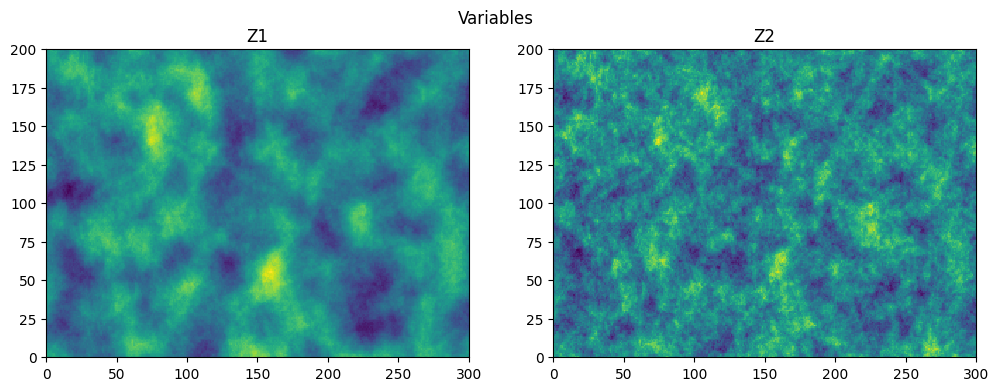

In [11]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,2,1)
ax1 = gp.raster(grid,name="Z1")
ax2 = fig.add_subplot(1,2,2)
ax2 = gp.raster(grid,name="Z2")
fig.decoration(title="Variables")

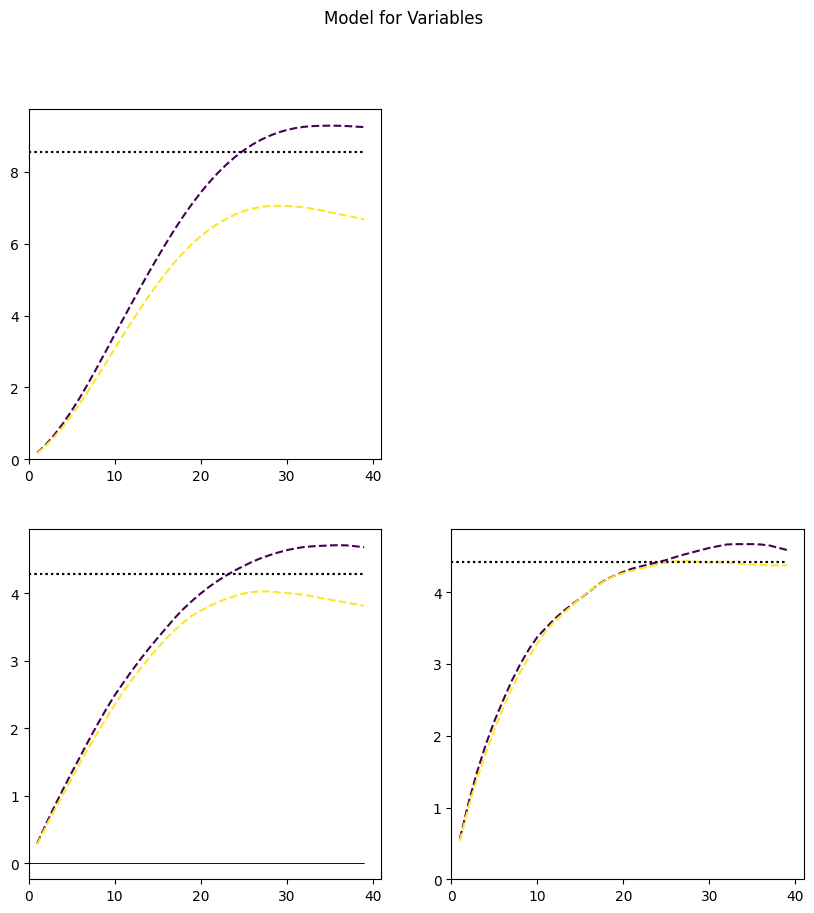

In [12]:
grid.setLocators(["Z*"],gl.ELoc.Z)

nlag=40
varioParamG = gl.VarioParam.createMultipleFromGrid(grid,nlag)
vario = gl.Vario.computeFromDb(varioParamG, grid)

axs = gp.varmod(vario)
gp.decoration(axs, title="Model for Variables")

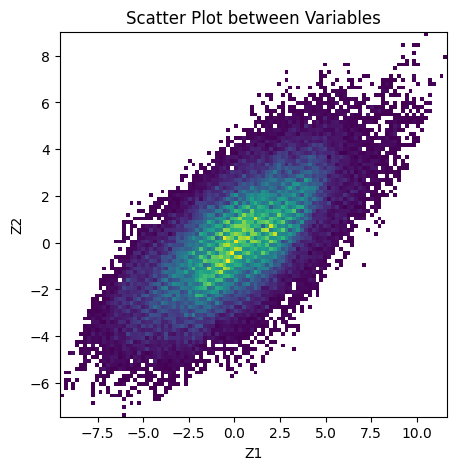

In [13]:
ax = gp.correlation(grid, "Z1", "Z2", bins=100, cmin=1)
ax.decoration(title="Scatter Plot between Variables")

### Sampling

This is performed by setting a threshold to be applied on a Uniform variable. 

In [14]:
grid["uniform"] = gl.VectorHelper.simulateUniform(grid.getNSample())

In [15]:
def masking(grid, thresh1, thresh2):
    m1 = grid["uniform"] < thresh1
    grid[m1, "Z1"] = np.nan
    m2 = grid["uniform"] < thresh2
    grid[m2, "Z2"] = np.nan
    
    mm = grid["uniform"] > min(thresh1, thresh2)
    grid["sel"] = mm*1
    grid.setLocator("sel", gl.ELoc.SEL)
    data = gl.Db.createReduce(grid)
    return data

Sample the exhaustive grid and create and Heteropic data set

In [16]:
data = masking(grid, 0.999,0.998)

We represent the heterotopic (nested) data set: in red where Z2 is informed and in black when Z1 is informed.

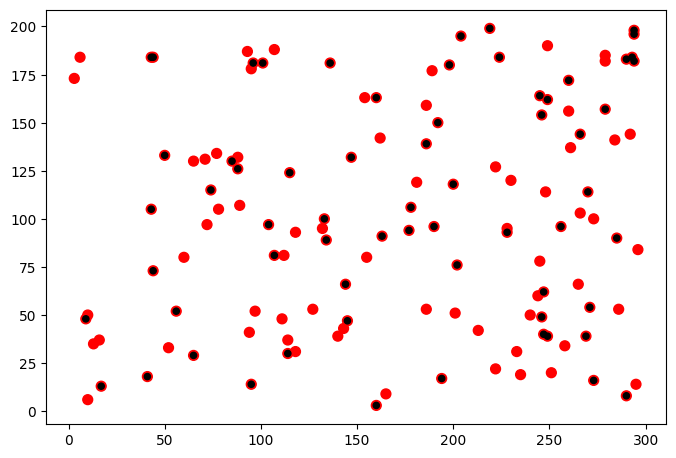

In [17]:
ax = gp.symbol(data, nameSize="Z2", flagCst=True, s=50)
ax = gp.symbol(data, nameSize="Z1", flagCst=True, s=20, c="black")

Calculating the simple and cross variograms based on these samples and fit them

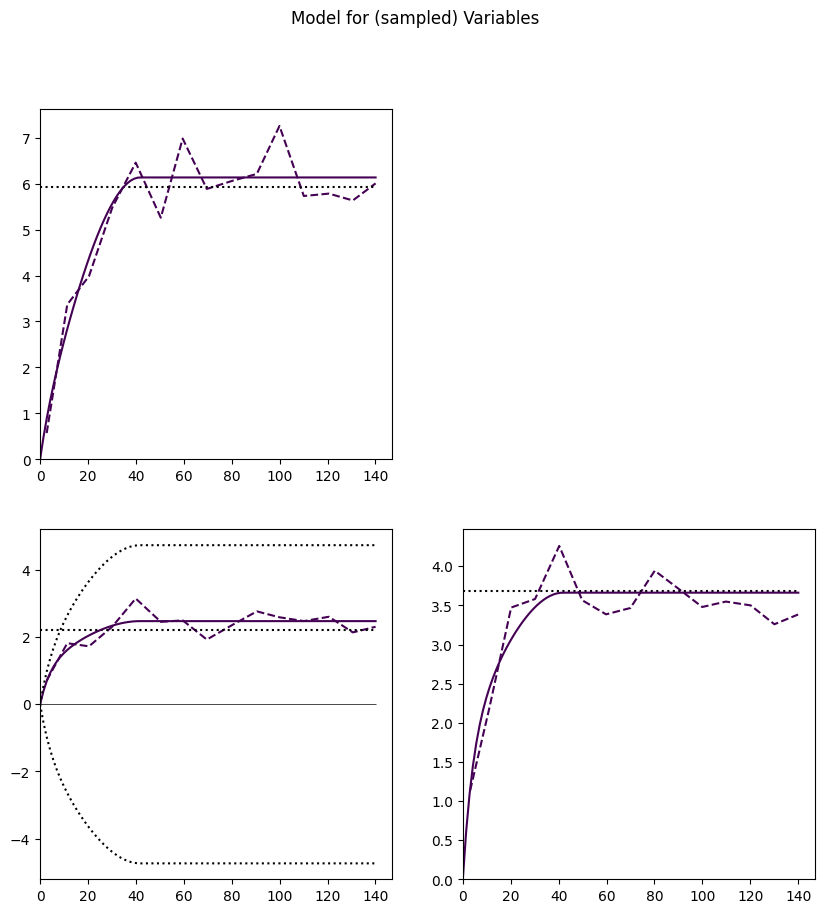

In [18]:
data.setLocators(["Z*"],gl.ELoc.Z)

nlag = 15
dlag = 10
varioParamS = gl.VarioParam.createOmniDirection(nlag, dlag)
vario = gl.Vario.computeFromDb(varioParamS, data)

model = gl.Model()
err = model.fit(vario, types=[gl.ECov.EXPONENTIAL, gl.ECov.SPHERICAL])
axs = gp.varmod(vario, model)
gp.decoration(axs, title="Model for (sampled) Variables")

### Performing Kriging and CoKriging

The main variable is the variable *Z1* and the auxiliary variable is *Z2*.
All subsequent estimations will be performed in Unique Neighborhood in the initial Grid (where the selection must be discarded beforehand).

In [19]:
neigh = gl.NeighUnique()
grid.clearSelection()

#### Considering Z1 as the main variable

When performing Kriging of *Z1*, the model of this variable is directly extracted from the bivariate model. This makes sense as *Z1* corresponds to the one with less samples.

##### Kriging

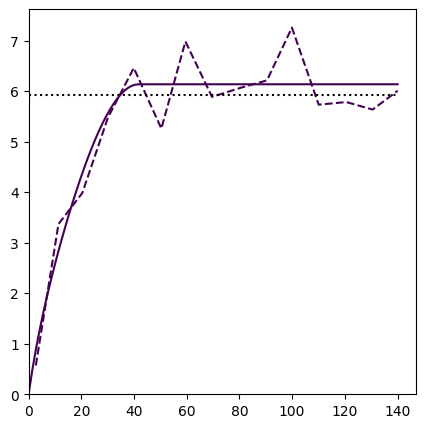

In [20]:
data.setLocator("Z1",gl.ELoc.Z,cleanSameLocator=True)
vario.mono = gl.Vario.createReduce(vario,[0],gl.VectorInt())
model.mono = gl.Model.createReduce(model,[0])
ax = gp.varmod(vario.mono, model.mono)

In [21]:
err = gl.kriging(data,grid,model.mono,neigh,namconv=gl.NamingConvention("Kriging"))
est1min = -5.20
est1max = +6.28
std1max = +2.48

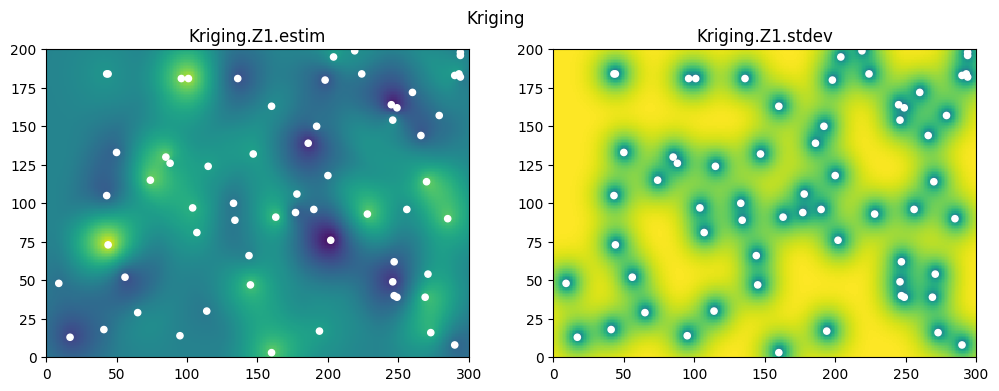

In [22]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,2,1)
ax1 = gp.raster(grid,name="Kriging.Z1.estim", vmin=est1min, vmax=est1max)
ax1 = gp.symbol(data, nameSize="Z1", flagCst=True, s=20, c="white")
ax2 = fig.add_subplot(1,2,2)
ax2 = gp.raster(grid,name="Kriging.Z1.stdev", vmin=0, vmax=std1max)
ax2 = gp.symbol(data, nameSize="Z1", flagCst=True, s=20, c="white")
fig.decoration(title="Kriging")

##### CoKriging

In [23]:
data.setLocators(["Z1","Z2"],gl.ELoc.Z)

In [24]:
err = gl.kriging(data,grid,model,neigh,namconv=gl.NamingConvention("CoKriging"))

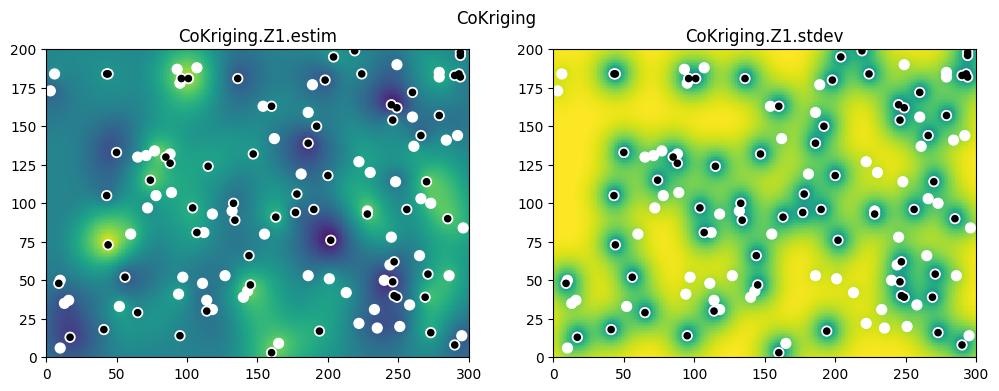

In [25]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,2,1)
ax1 = gp.raster(grid,name="CoKriging.Z1.estim", vmin=est1min, vmax=est1max)
ax1 = gp.symbol(data, nameSize="Z2", flagCst=True, s=50, c="white")
ax1 = gp.symbol(data, nameSize="Z1", flagCst=True, s=20, c="black")
ax2 = fig.add_subplot(1,2,2)
ax2 = gp.raster(grid,name="CoKriging.Z1.stdev", vmin=0, vmax=std1max)
ax2 = gp.symbol(data, nameSize="Z2", flagCst=True, s=50, c="white")
ax2 = gp.symbol(data, nameSize="Z1", flagCst=True, s=20, c="black")
fig.decoration(title="CoKriging")

Comparing CoKriging and Kriging on the main variable Z1

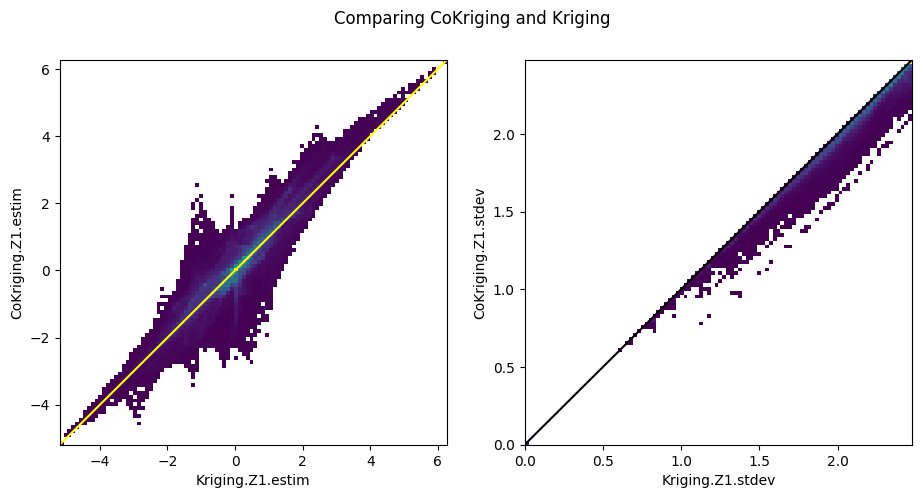

In [26]:
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(1,2,1)
ax1 = gp.correlation(grid,"Kriging.Z1.estim","CoKriging.Z1.estim",bins=100, cmin=1,
                   diagLine=True, diagColor="yellow", flagSameAxes=True)
ax2 = fig.add_subplot(1,2,2)
ax2 = gp.correlation(grid,"Kriging.Z1.stdev","CoKriging.Z1.stdev",bins=100, cmin=1,
                   diagLine=True, diagColor="black", flagSameAxes=True)
fig.decoration(title="Comparing CoKriging and Kriging")

#### Considering Z2 as the main variable

This time, we consider *Z2* as the target variable.

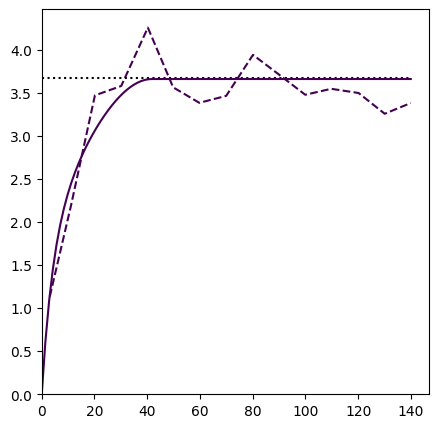

In [27]:
data.setLocator("Z2",gl.ELoc.Z,cleanSameLocator=True)
vario.mono = gl.Vario.createReduce(vario,[1],gl.VectorInt())
model.mono = gl.Model.createReduce(model,[1])
ax = gp.varmod(vario.mono, model.mono)

In [28]:
err = gl.kriging(data,grid,model.mono,neigh,namconv=gl.NamingConvention("Kriging"))
est2min = -5.47
est2max = +4.16
std2max = +1.92

>>> Matrix X is missing (required)
    (generated in KrigingAlgebraSimpleCase::_isPresentMatrix)


In [ ]:
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(1,2,1)
ax1 = gp.raster(grid,name="Kriging.Z2.estim", vmin=est2min, vmax=est2max)
ax1 = gp.symbol(data, nameSize="Z2", flagCst=True, s=20, c="white")
ax2 = fig.add_subplot(1,2,2)
ax2 = gp.raster(grid,name="Kriging.Z2.stdev", vmin=0, vmax=std2max)
ax2 = gp.symbol(data, nameSize="Z2", flagCst=True, s=20, c="white")
fig.decoration(title="Kriging")

Comparing CoKriging of Z2 (using Z1 as an auxiliary variable) to the Kriging of Z2.

In [ ]:
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(1,2,1)
ax1 = gp.correlation(grid,"Kriging.Z2.estim","CoKriging.Z2.estim",bins=100, cmin=1,
                   diagLine=True, diagColor="yellow", flagSameAxes=True)
ax2 = fig.add_subplot(1,2,2)
ax2 = gp.correlation(grid,"Kriging.Z2.stdev","CoKriging.Z2.stdev",bins=100, cmin=1,
                   diagLine=True, diagColor="black", flagSameAxes=True)
fig.decoration(title="Comparing CoKriging and Kriging")

As expected, the improvement in using Z1 as secondary variable is minor as it does not provide any information at samples where Z2 is not informed. Nevertheless, it still carries additional information: this is implies an improvement ... unless CoKriging presents some simplification, i.e.:
- the variables are spatially uncorrelated
- the variables are intrinsically correlated
- the variables correspond to a Markov model

None of these options are present in the current Model.

## CoKriging simplifications

This simple test demonstrates the different simplifications of the cokriging. 

The minimum data set is composed of 2 variables defined at 2 data samples.

In [ ]:
data = gl.Db.create()
data["x1"] = [-10,15]
data["x2"] = [  0, 0]
data["z1"] = [ -1, 2]
data["z2"] = [  3, 5]
data.setLocators(["x1","x2"], gl.ELoc.X)
data.setLocators(["z1","z2"], gl.ELoc.Z)

target = gl.DbGrid.create(nx=[1,1])

neigh = gl.NeighUnique()


We define a standard workflow that will be performed for different Models.

In [ ]:
def test_kriging(model, title, flagShort=True):
    if not flagShort:
        gl.OptDbg.setReference(1)
    
    # Kriging the variables individually
    print("====================================================")
    print("Kriging Variable #1")
    print("====================================================")
    data1 = data.clone()
    data1.setLocator("z1",gl.ELoc.Z)
    model1 = gl.Model.createReduce(model,[0])
    if flagShort:
        result = gl.krigtest(data1,target,model1,neigh)
        print(result.wgt)
    else:
        err = gl.kriging(data1,target,model1,neigh,
                        namconv=gl.NamingConvention(title + "_K"))
    
    print("====================================================")
    print("Kriging Variable #2")
    print("====================================================")
    data2 = data.clone()
    data2.setLocator("z2",gl.ELoc.Z)
    model2 = gl.Model.createReduce(model,[1])
    if flagShort:
        result = gl.krigtest(data2,target,model2,neigh)
        print(result.wgt)
    else:
        err = gl.kriging(data2,target,model2,neigh,
                         namconv=gl.NamingConvention(title + "_K"))
    
    # CoKriging
    print("====================================================")
    print("CoKriging")
    print("====================================================")
    if flagShort:
        result = gl.krigtest(data,target,model,neigh)
        print(result.wgt)
    else:
        err = gl.kriging(data,target,model,neigh,
                         namconv=gl.NamingConvention(title + "_COK"))
        
    gl.OptDbg.setReference(0)

### Variables spatially independent

Define a Model with spatially independent variables

In [ ]:
model = gl.Model.createFromParam(gl.ECov.SPHERICAL, range=30, sills=np.array([[1,0],[0,1]]))
print(model)

Perform CoKriging and Kriging

For the estimation of the single target site of the output grid, we ask for the whole display of the calculations: we will essentially pay attention to the set of weights.

In [ ]:
test_kriging(model , "No_Correlation", flagShort=False)

For the next comparison, we will focus on the set of weights only.

In [ ]:
test_kriging(model , "No_Correlation")

### Intrinsic Correlation

Define a Model with Intrinsic Correlation

In [ ]:
model = gl.Model(2,2)
model.addCovFromParam(gl.ECov.NUGGET,sills=np.array([[8,-2],[-2,5]]))
model.addCovFromParam(gl.ECov.SPHERICAL,range=20,sills=np.array([[32,-8],[-8,20]]))
print(model)

Perform CoKriging and Krigings

In [ ]:
test_kriging(model, "Intrinsic_Correlation")

### Markov Model

In [ ]:
model = gl.Model(2,2)
model.addCovFromParam(gl.ECov.CUBIC,range=50,sills=np.array([[1,2],[2,4]]))
model.addCovFromParam(gl.ECov.SPHERICAL,range=20,sills=np.array([[0,0],[0,9]]))
print(model)

Perform CoKriging and Krigings

In [ ]:
test_kriging(model, "Markov_COK")